In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import time    

%matplotlib inline

In [2]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [3]:
def augment_data(file_dir, n_generated_samples, save_to_dir):

    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    

    for filename in listdir(file_dir):
        
        image = cv2.imread(file_dir + '\\' + filename)
        
        image = image.reshape((1,)+image.shape)
        
        save_prefix = 'aug_' + filename[:-4]
        
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [4]:
start_time = time.time()

augmented_data_path = r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset/'

augment_data(file_dir=r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset\yes', n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset\no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:5:4.0


In [5]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    m_pos = len(listdir(r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset\yes'))
    m_neg = len(listdir(r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset\no'))

    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [6]:
data_summary(augmented_data_path)

Number of examples: 2318
Percentage of positive examples: 53.49439171699741%, number of pos examples: 1240
Percentage of negative examples: 46.50560828300259%, number of neg examples: 1078


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [8]:
def crop_brain_contour(image, plot=False):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

   
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

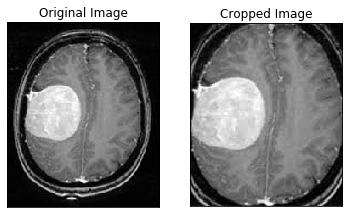

In [9]:
ex_img = cv2.imread(r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset\yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [10]:

def load_data(dir_list, image_size):


    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '\\' + filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [11]:
augmented_path = r'C:\Users\parve\Desktop\BrainTumourDetection\brain_tumor_dataset/'

augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2318
X shape is: (2318, 240, 240, 3)
y shape is: (2318, 1)


In [12]:
def plot_sample_images(X, y, n=50):

    
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

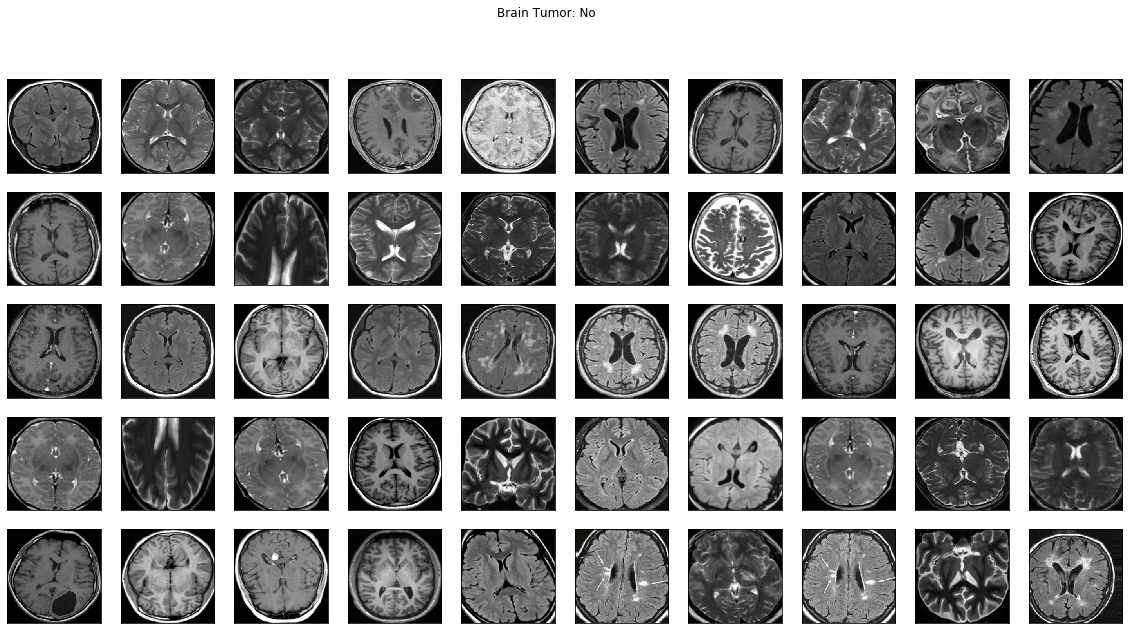

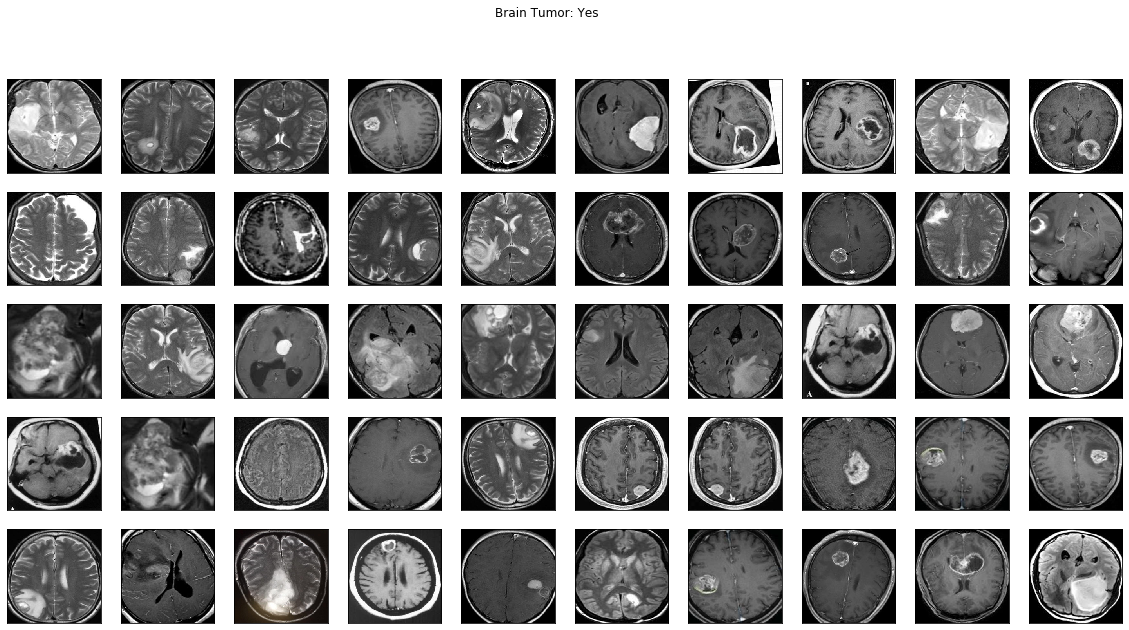

In [13]:
plot_sample_images(X, y)

In [14]:
def split_data(X, y, test_size=0.2):
       
  
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [16]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1622
number of development examples = 348
number of test examples = 348
X_train shape: (1622, 240, 240, 3)
Y_train shape: (1622, 1)
X_val (dev) shape: (348, 240, 240, 3)
Y_val (dev) shape: (348, 1)
X_test shape: (348, 240, 240, 3)
Y_test shape: (348, 1)


In [17]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [18]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score


In [19]:
def build_model(input_shape):

    X_input = Input(input_shape)
    
    X = ZeroPadding2D((2, 2))(X_input) 

    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    
    X = MaxPooling2D((4, 4), name='max_pool0')(X) 
    
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    X = Flatten()(X) 

    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [20]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [23]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
51/51 [==============================] - 158s 3s/step - loss: 0.8234 - accuracy: 0.6116 - val_loss: 0.6658 - val_accuracy: 0.5632
Epoch 2/10
51/51 [==============================] - 172s 3s/step - loss: 0.4895 - accuracy: 0.7528 - val_loss: 0.5922 - val_accuracy: 0.7069
Epoch 3/10
51/51 [==============================] - 183s 4s/step - loss: 0.4318 - accuracy: 0.8070 - val_loss: 0.5546 - val_accuracy: 0.7270
Epoch 4/10
51/51 [==============================] - 208s 4s/step - loss: 0.3787 - accuracy: 0.8329 - val_loss: 0.6041 - val_accuracy: 0.6494
Epoch 5/10
51/51 [==============================] - 186s 4s/step - loss: 0.3281 - accuracy: 0.8551 - val_loss: 0.5013 - val_accuracy: 0.7816
Epoch 6/10
51/51 [==============================] - 166s 3s/step - loss: 0.2950 - accuracy: 0.8798 - val_loss: 0.4776 - val_accuracy: 0.7500
Epoch 7/10
51/51 [==============================] - 166s 3s/step - loss: 0.2646 - accuracy: 0.8933 - val_loss: 0.3903 - val_accuracy: 0.8218
Epoch 8/10
51

In [25]:
history = model.history.history

In [26]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [34]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

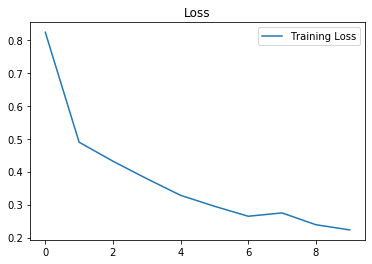

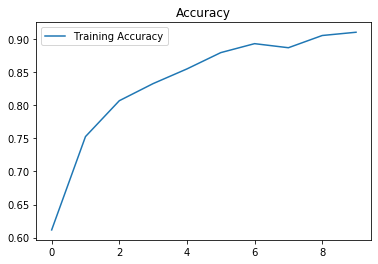

In [35]:
plot_metrics(history)